Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-7cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-8cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-9cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-10cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-11cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-12cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-14cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-15cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-16cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-17cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-18cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-19cc_openmsp430_0.csv
Loading data from: glitchsweep_

Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-33cc_openmsp430_4.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-7cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-8cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-9cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-10cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-11cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-12cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-14cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-15cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-16cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-17cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-18cc_openmsp430_5.csv
Loading data from: glitchsweep_

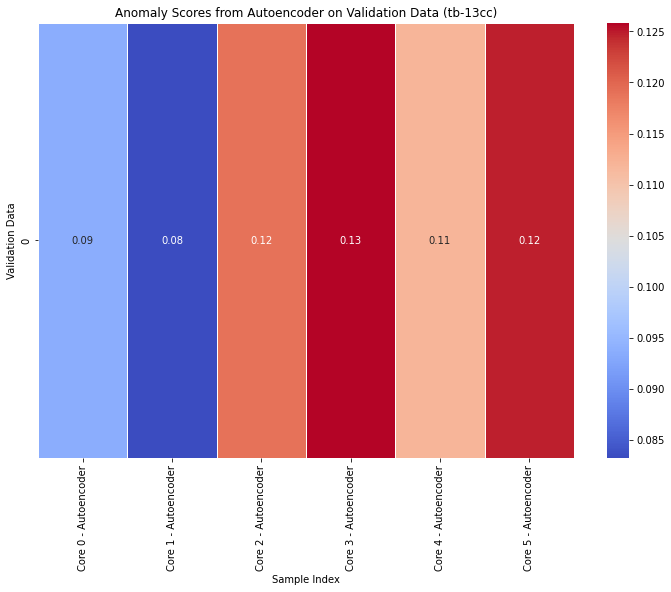

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base directory
base_dir = 'glitchsweep_fsm_red'

# ID sets (representing different hash configurations)
id_sets = ['openmsp430_0', 'openmsp430_1', 'openmsp430_2', 'openmsp430_3', 'openmsp430_4', 'openmsp430_5']

# Folders for training and validation (these are part of file names, not actual directories)
train_folder_names = [
    'tb-7cc', 'tb-8cc', 'tb-9cc', 'tb-10cc', 'tb-11cc', 'tb-12cc',
    'tb-14cc', 'tb-15cc', 'tb-16cc', 'tb-17cc', 'tb-18cc', 'tb-19cc',
    'tb-21cc', 'tb-22cc', 'tb-23cc', 'tb-24cc', 'tb-25cc', 'tb-26cc',
    'tb-28cc', 'tb-29cc', 'tb-31cc', 'tb-32cc', 'tb-33cc'
]
validation_folder_name = 'tb-30cc'  # This is part of the file name, not an actual folder

# Function to read and preprocess CSV files into 2D arrays
def read_and_preprocess_csv(file_path):
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path, header=None, skiprows=1)  # Skip header
    if df.empty:
        raise ValueError(f"No data found in {file_path}.")
    
    # Convert hashed values to numeric using Label Encoding
    def convert_hashes_to_numeric(df):
        label_encoders = []
        for column in df.columns:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column].astype(str))
            label_encoders.append(le)
        return df, label_encoders

    df_numeric, label_encoders = convert_hashes_to_numeric(df)
    return df_numeric.values  # Return as a NumPy array

# Step 1: Create the 3D training dataset
train_data_3d = []

for set_name in id_sets:
    for train_folder_name in train_folder_names:
        train_file = f'extracted_hashes_{train_folder_name}_{set_name}.csv'
        train_file_path = os.path.join(base_dir, train_file)

        if os.path.exists(train_file_path):
            try:
                # Read and preprocess the CSV file into a 2D array (28, 31)
                data_2d = read_and_preprocess_csv(train_file_path)
                if data_2d.shape == (28, 31):  # Ensure it has the correct shape
                    train_data_3d.append(data_2d)
                else:
                    print(f"Unexpected data shape {data_2d.shape} in {train_file_path}. Skipping this file.")
            except Exception as e:
                print(f"Error reading or processing {train_file} in {train_folder_name}: {e}")
        else:
            print(f"Missing training file: {train_file} in {train_folder_name}")

# Convert list to a 3D NumPy array
train_data_3d = np.array(train_data_3d)  # Shape will be (138, 28, 31)

# Step 2: Train Autoencoder on the 3D training dataset

# Reshape train_data_3d to (138, 28*31) for Autoencoder
X_train = train_data_3d.reshape(138, -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define Autoencoder model with better tuning
input_layer = Input(shape=(X_train_scaled.shape[1],))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dropout(0.2)(encoded)
encoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dropout(0.2)(decoded)
decoded = Dense(512, activation='relu')(decoded)
decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the Autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, 
                epochs=300, 
                batch_size=32, 
                validation_split=0.1, 
                verbose=1,
                callbacks=[early_stopping])

# Step 3: Create the 3D validation dataset and validate the Autoencoder
validation_data_3d = []

for set_name in id_sets:
    validate_file = f'fault_extracted_hashes_{validation_folder_name}_{set_name}.csv'
    validate_file_path = os.path.join(base_dir, validate_file)

    if os.path.exists(validate_file_path):
        try:
            # Read and preprocess the CSV file into a 2D array (28, 31)
            data_2d = read_and_preprocess_csv(validate_file_path)
            if data_2d.shape == (28, 31):  # Ensure it has the correct shape
                validation_data_3d.append(data_2d)
            else:
                print(f"Unexpected data shape {data_2d.shape} in {validate_file_path}. Skipping this file.")
        except Exception as e:
            print(f"Error processing {validate_file} in {validation_folder_name}: {e}")
    else:
        print(f"Missing validation file: {validate_file} in {validation_folder_name}")

# Convert list to a 3D NumPy array
validation_data_3d = np.array(validation_data_3d)  # Shape should be (6, 28, 31)

# Step 4: Validate each dataset in the validation data
validation_results = {}

for i, X_validate_2d in enumerate(validation_data_3d):
    # Reshape to (1, 28*31) for Autoencoder
    X_validate = X_validate_2d.reshape(1, -1)
    X_validate_scaled = scaler.transform(X_validate)

    # Validate Autoencoder
    reconstructions = autoencoder.predict(X_validate_scaled)
    autoencoder_mse = np.mean(np.power(X_validate_scaled - reconstructions, 2), axis=1)

    # Store results
    validation_results[f'Core {i} - Autoencoder'] = autoencoder_mse

# Step 5: Plot the validation results
results_df = pd.DataFrame(validation_results)
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title(f'Anomaly Scores from Autoencoder on Validation Data (tb-13cc)')
plt.xlabel('Sample Index')
plt.ylabel('Validation Data')
plt.show()
# Step 4: Validate each dataset in the validation data



Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-7cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-8cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-9cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-10cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-11cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-12cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-14cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-15cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-16cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-17cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-18cc_openmsp430_0.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-19cc_openmsp430_0.csv
Loading data from: glitchsweep_

Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-7cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-8cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-9cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-10cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-11cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-12cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-14cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-15cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-16cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-17cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-18cc_openmsp430_5.csv
Loading data from: glitchsweep_fsm_red/extracted_hashes_tb-19cc_openmsp430_5.csv
Loading data from: glitchsweep_

8/8 [==============================] - 0s 27ms/step - loss: 0.6671 - val_loss: 0.5775
Epoch 66/500
8/8 [==============================] - 0s 28ms/step - loss: 0.6543 - val_loss: 0.5648
Epoch 67/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6419 - val_loss: 0.5524
Epoch 68/500
8/8 [==============================] - 0s 26ms/step - loss: 0.6294 - val_loss: 0.5406
Epoch 69/500
8/8 [==============================] - 0s 25ms/step - loss: 0.6181 - val_loss: 0.5290
Epoch 70/500
8/8 [==============================] - 0s 27ms/step - loss: 0.6066 - val_loss: 0.5181
Epoch 71/500
8/8 [==============================] - 0s 32ms/step - loss: 0.5956 - val_loss: 0.5075
Epoch 72/500
8/8 [==============================] - 0s 29ms/step - loss: 0.5850 - val_loss: 0.4970
Epoch 73/500
8/8 [==============================] - 0s 25ms/step - loss: 0.5748 - val_loss: 0.4870
Epoch 74/500
8/8 [==============================] - 0s 23ms/step - loss: 0.5650 - val_loss: 0.4774
Epoch 75/500
8/8 [=====

8/8 [==============================] - 0s 25ms/step - loss: 0.3120 - val_loss: 0.2289
Epoch 148/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3113 - val_loss: 0.2282
Epoch 149/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3106 - val_loss: 0.2274
Epoch 150/500
8/8 [==============================] - 0s 23ms/step - loss: 0.3097 - val_loss: 0.2267
Epoch 151/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3091 - val_loss: 0.2259
Epoch 152/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3081 - val_loss: 0.2252
Epoch 153/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3075 - val_loss: 0.2244
Epoch 154/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3068 - val_loss: 0.2237
Epoch 155/500
8/8 [==============================] - 0s 23ms/step - loss: 0.3061 - val_loss: 0.2231
Epoch 156/500
8/8 [==============================] - 0s 24ms/step - loss: 0.3054 - val_loss: 0.2223
Epoch 157/500


8/8 [==============================] - 0s 25ms/step - loss: 0.2840 - val_loss: 0.2003
Epoch 230/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2837 - val_loss: 0.2002
Epoch 231/500
8/8 [==============================] - 0s 29ms/step - loss: 0.2839 - val_loss: 0.2001
Epoch 232/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2836 - val_loss: 0.2000
Epoch 233/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2836 - val_loss: 0.1999
Epoch 234/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2835 - val_loss: 0.1998
Epoch 235/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2833 - val_loss: 0.1996
Epoch 236/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2833 - val_loss: 0.1996
Epoch 237/500
8/8 [==============================] - 0s 28ms/step - loss: 0.2830 - val_loss: 0.1995
Epoch 238/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2831 - val_loss: 0.1994
Epoch 239/500


8/8 [==============================] - 0s 29ms/step - loss: 0.2797 - val_loss: 0.1958
Epoch 312/500
8/8 [==============================] - 0s 31ms/step - loss: 0.2797 - val_loss: 0.1958
Epoch 313/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2795 - val_loss: 0.1957
Epoch 314/500
8/8 [==============================] - 0s 29ms/step - loss: 0.2796 - val_loss: 0.1957
Epoch 315/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2795 - val_loss: 0.1957
Epoch 316/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2794 - val_loss: 0.1956
Epoch 317/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2795 - val_loss: 0.1956
Epoch 318/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2796 - val_loss: 0.1957
Epoch 319/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2795 - val_loss: 0.1956
Epoch 320/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2794 - val_loss: 0.1956
Epoch 321/500


8/8 [==============================] - 0s 28ms/step - loss: 0.2783 - val_loss: 0.1947
Epoch 394/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2781 - val_loss: 0.1947
Epoch 395/500
8/8 [==============================] - 0s 29ms/step - loss: 0.2781 - val_loss: 0.1947
Epoch 396/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2782 - val_loss: 0.1947
Epoch 397/500
8/8 [==============================] - 0s 28ms/step - loss: 0.2782 - val_loss: 0.1947
Epoch 398/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2784 - val_loss: 0.1947
Epoch 399/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2781 - val_loss: 0.1947
Epoch 400/500
8/8 [==============================] - 0s 30ms/step - loss: 0.2782 - val_loss: 0.1947
Epoch 401/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2784 - val_loss: 0.1947
Epoch 402/500
8/8 [==============================] - 0s 29ms/step - loss: 0.2783 - val_loss: 0.1946
Epoch 403/500


8/8 [==============================] - 0s 26ms/step - loss: 0.2773 - val_loss: 0.1943
Epoch 476/500
8/8 [==============================] - 0s 26ms/step - loss: 0.2776 - val_loss: 0.1944
Epoch 477/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2776 - val_loss: 0.1944
Epoch 478/500
8/8 [==============================] - 0s 28ms/step - loss: 0.2774 - val_loss: 0.1943
Epoch 479/500
8/8 [==============================] - 0s 31ms/step - loss: 0.2773 - val_loss: 0.1943
Epoch 480/500
8/8 [==============================] - 0s 29ms/step - loss: 0.2776 - val_loss: 0.1942
Epoch 481/500
8/8 [==============================] - 0s 27ms/step - loss: 0.2774 - val_loss: 0.1943
Epoch 482/500
8/8 [==============================] - 0s 24ms/step - loss: 0.2775 - val_loss: 0.1943
Epoch 483/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2773 - val_loss: 0.1943
Epoch 484/500
8/8 [==============================] - 0s 25ms/step - loss: 0.2772 - val_loss: 0.1943
Epoch 485/500


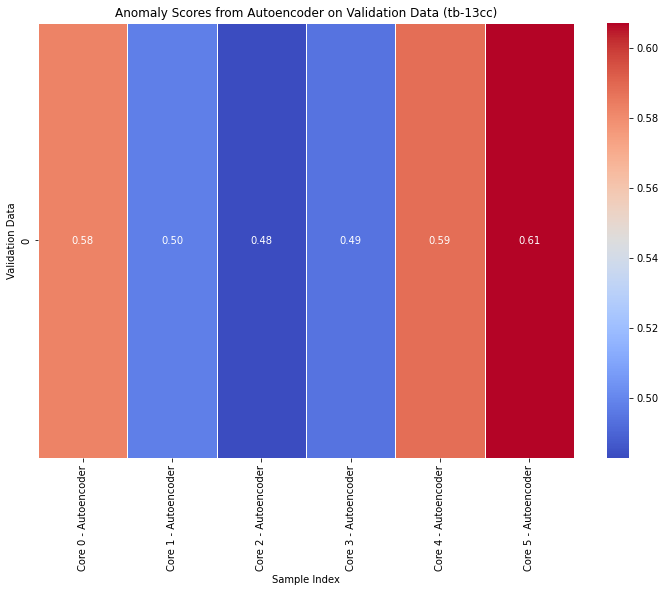

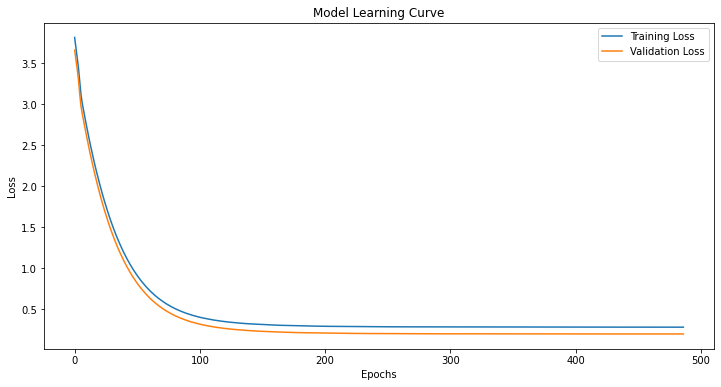

In [3]:
# import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Define the base directory
base_dir = 'glitchsweep_fsm_red'

# ID sets (representing different hash configurations)
id_sets = ['openmsp430_0', 'openmsp430_1', 'openmsp430_2', 'openmsp430_3', 'openmsp430_4', 'openmsp430_5']

# Folders for training and validation (these are part of file names, not actual directories)
train_folder_names = [
    'tb-7cc', 'tb-8cc', 'tb-9cc', 'tb-10cc', 'tb-11cc', 'tb-12cc',
    'tb-14cc', 'tb-15cc', 'tb-16cc', 'tb-17cc', 'tb-18cc', 'tb-19cc',
    'tb-21cc', 'tb-22cc', 'tb-23cc', 'tb-24cc', 'tb-25cc', 'tb-26cc',
    'tb-28cc', 'tb-29cc', 'tb-31cc', 'tb-32cc', 'tb-33cc'
]
validation_folder_name = 'tb-13cc'  # This is part of the file name, not an actual folder

# Function to read and preprocess CSV files into 2D arrays
def read_and_preprocess_csv(file_path):
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path, header=None, skiprows=1)  # Skip header
    if df.empty:
        raise ValueError(f"No data found in {file_path}.")
    
    # Convert hashed values to numeric using Label Encoding
    def convert_hashes_to_numeric(df):
        label_encoders = []
        for column in df.columns:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column].astype(str))
            label_encoders.append(le)
        return df, label_encoders

    df_numeric, label_encoders = convert_hashes_to_numeric(df)
    return df_numeric.values  # Return as a NumPy array

# Step 1: Create the 3D training dataset
train_data_3d = []

for set_name in id_sets:
    for train_folder_name in train_folder_names:
        train_file = f'extracted_hashes_{train_folder_name}_{set_name}.csv'
        train_file_path = os.path.join(base_dir, train_file)

        if os.path.exists(train_file_path):
            try:
                # Read and preprocess the CSV file into a 2D array (28, 31)
                data_2d = read_and_preprocess_csv(train_file_path)
                if data_2d.shape == (28, 31):  # Ensure it has the correct shape
                    train_data_3d.append(data_2d)
                else:
                    print(f"Unexpected data shape {data_2d.shape} in {train_file_path}. Skipping this file.")
            except Exception as e:
                print(f"Error reading or processing {train_file} in {train_folder_name}: {e}")
        else:
            print(f"Missing training file: {train_file} in {train_folder_name}")

# Convert list to a 3D NumPy array
train_data_3d = np.array(train_data_3d)  # Shape will be (138, 28, 31)

# Step 2: Train Autoencoder on the 3D training dataset

# Reshape train_data_3d to (138, 28*31) for Autoencoder
X_train = train_data_3d.reshape(138, -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define Autoencoder model with better tuning
input_layer = Input(shape=(X_train_scaled.shape[1],))
encoded = Dense(1024, kernel_regularizer=l2(0.001))(input_layer)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(512, kernel_regularizer=l2(0.001))(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(256, kernel_regularizer=l2(0.001))(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(128, kernel_regularizer=l2(0.001))(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)

decoded = Dense(256, kernel_regularizer=l2(0.001))(encoded)
decoded = LeakyReLU(alpha=0.1)(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(512, kernel_regularizer=l2(0.001))(decoded)
decoded = LeakyReLU(alpha=0.1)(decoded)
decoded = Dropout(0.3)(decoded)
decoded = Dense(1024, kernel_regularizer=l2(0.001))(decoded)
decoded = LeakyReLU(alpha=0.1)(decoded)
decoded = Dense(X_train_scaled.shape[1], activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the Autoencoder
history = autoencoder.fit(X_train_scaled, X_train_scaled, 
                          epochs=500, 
                          batch_size=16, 
                          validation_split=0.1, 
                          verbose=1,
                          callbacks=[early_stopping])

# Step 3: Create the 3D validation dataset and validate the Autoencoder
validation_data_3d = []

for set_name in id_sets:
    validate_file = f'fault_extracted_hashes_{validation_folder_name}_{set_name}.csv'
    validate_file_path = os.path.join(base_dir, validate_file)

    if os.path.exists(validate_file_path):
        try:
            # Read and preprocess the CSV file into a 2D array (28, 31)
            data_2d = read_and_preprocess_csv(validate_file_path)
            if data_2d.shape == (28, 31):  # Ensure it has the correct shape
                validation_data_3d.append(data_2d)
            else:
                print(f"Unexpected data shape {data_2d.shape} in {validate_file_path}. Skipping this file.")
        except Exception as e:
            print(f"Error processing {validate_file} in {validation_folder_name}: {e}")
    else:
        print(f"Missing validation file: {validate_file} in {validation_folder_name}")

# Convert list to a 3D NumPy array
validation_data_3d = np.array(validation_data_3d)  # Shape should be (6, 28, 31)

# Step 4: Validate each dataset in the validation data
validation_results = {}

for i, X_validate_2d in enumerate(validation_data_3d):
    # Reshape to (1, 28*31) for Autoencoder
    X_validate = X_validate_2d.reshape(1, -1)
    X_validate_scaled = scaler.transform(X_validate)

    # Validate Autoencoder
    reconstructions = autoencoder.predict(X_validate_scaled)
    autoencoder_mse = np.mean(np.power(X_validate_scaled - reconstructions, 2), axis=1)

    # Store results
    validation_results[f'Core {i} - Autoencoder'] = autoencoder_mse

# Step 5: Plot the validation results
results_df = pd.DataFrame(validation_results)
plt.figure(figsize=(12, 8))
sns.heatmap(results_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title(f'Anomaly Scores from Autoencoder on Validation Data (tb-13cc)')
plt.xlabel('Sample Index')
plt.ylabel('Validation Data')
plt.show()

# Step 6: Plot the Learning Curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Step 1: Define the bit strings for each core
core_bitstrings = {
"Core0": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011111111010101010101010111111111111111111111111111111111111111111111111111110110110011100011111111111111111101111100001111011110010000101111100111111110000000000111011111111111111111010111110111010001011111111011111111011011010011111110111111101111111011111110111111111111111011111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001110111000000001111111111111111111111111111111101111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000000010010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000000000000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000001000000000000000000000000000000000000000000000000000000000000000000000000100000000000000010000000000000001000000000000000000000000000000000000000000000000000000",
"Core1": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011111111010101010101010111111111111111111111111111111111111111111111111111110110001111110010111111111111111101111100001111101001010000101111000111111110000000000101011111011111111111100101010111010001011111111011111111011011010011111110111111101111111011111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001110111000000011111111111111111111111111111111111111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000000010010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000",
"Core2": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011111111010101010101010111111111111111111111111111111111111111111111111111110110001111110010111111111111111101111100001111101001010000101111000111111110000000000101011111011111111111100101010111010001011111111011111111011011010011111110111111101111111011111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111101001110111000000011111111111111111111111111111111111111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000000010010100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000",
"Core3": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011111111010101010101010111111111111111111111111111111111111111111111111111101011110111100011111111111111111111110100001111101011010000011101101111111111111111111011001011111111111111100101001011110001111111111111111101011111010011111110111111101111111011111110111111111111111011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110111000000001111111111111111111111111111111110111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000001001001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000001000000000000000000000000000000000000000000000000000000",
"Core4": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011111111010101010101010111111111111111111111111111111111111111111111111111111111111111111111111111111111111101111100001111111100110000110111111111111101111111111111101111111111111111100101111111010001010011111111111111011111010011111110111111101111111011111110111111111111111111111111111111101111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100101111111111111100000111111110011111111111111111111111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000001001001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000010000000000000001000000000000000000000000000000000000000000000000000000",
"Core5": "0000000000000000000111111111000000000000000000000000000000000000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000111111111111100000000000001111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111000000000011111111111011101111011010111010101010101010111111111111111111111111111111111111111111111111111111100000000011001111111111111111101111100001111110100010000101110000111111110000000000110011100011111111111100101100111010001011111111011111111011011001111111110111111101111111011111110111111111111111111111111111111110111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111100111110111000000000000111111010001111111111111111111111110000111111111011110111111111111111110000000000000001111111111111111110111001110000000001000000100000000010000100100000011111000100000000001001001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100010000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001010000000000000000000000001000000000000000000000000000000000000000000000000000000"

}

# Step 2: Convert the bit strings to arrays of integers
core_arrays = {core: np.array([int(bit) for bit in bitstring]) for core, bitstring in core_bitstrings.items()}

# Step 3: Calculate the number of differences for each core
differences = {}
cores = list(core_arrays.keys())

for i, core in enumerate(cores):
    differences[core] = 0
    for j, compare_core in enumerate(cores):
        if i != j:
            # Calculate the number of differing bits
            differences[core] += np.sum(core_arrays[core] != core_arrays[compare_core])

# Step 4: Identify the core with the maximum differences
abnormal_core = max(differences, key=differences.get)
print("Differences per core:", differences)
print(f"The core that is different based on the bitwise comparison is: {abnormal_core} with {differences[abnormal_core]} differences.")


In [ ]:
import numpy as np

# Step 1: Define the bit strings for each core
core_bitstrings = {
    "Core0": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001000000000010100000000000000000000000001111000001111110111110001000000000000000000000000000010000000000000001101010000100000000000000000000011010000010000000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111111100000111101000000000000000000000000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000",
    "Core1": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001010000100001110000000000000000000000001111000001111110111110101000000000000000000000000000010000000000000000100010000100000000000000000110010010000010000000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111111100000111101000000000000000000000000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000",
    "Core2": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001100100110001110000000000000000000000101111000010000010111100100000000000001000000000000000000000000000000010100001100000001000110000000000000010100010110000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111000000000000000000000000000000000100000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000",
    "Core3": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001100100110001110000000000000000000000101111000010000010111100100000000000001000000000000000000000000000000010100001100000001000110000000000000010100010110000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111000000000000000000000000000000000100000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000",
    "Core4": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001000000000010100000000000000000000000001111000001111110111110101000000000000000000000000001010000000000000001101010000100000000100000000110010010000010000000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111111100000111101000000000000000000000000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000",
    "Core5": "110000000000010001000010000000000000000000000000000000000000000000000000000000000000000000000000001100100110001110000000000000000000000101111000010000010111100100000000000001000000000000001000000000000000010100001100000001000110000000000000010100010110000000100000001000000010000000100000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001011000100011111111000000000000000100000000000000000100000111100000000010000100000000000000000111111111111111000000000000000000111100111000000000100000010000000001000010010000001111100010000000000"
}

# Step 2: Convert the bit strings to arrays of integers
core_arrays = {core: np.array([int(bit) for bit in bitstring]) for core, bitstring in core_bitstrings.items()}

# Step 3: Calculate the number of differences for each core
differences = {}
cores = list(core_arrays.keys())

for i, core in enumerate(cores):
    differences[core] = 0
    for j, compare_core in enumerate(cores):
        if i != j:
            # Calculate the number of differing bits
            differences[core] += np.sum(core_arrays[core] != core_arrays[compare_core])

# Step 4: Identify the core with the maximum differences
abnormal_core = max(differences, key=differences.get)
print("Differences per core:", differences)
print(f"The core that is different based on the bitwise comparison is: {abnormal_core} with {differences[abnormal_core]} differences.")
